In [6]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from global_land_mask import globe

from scipy.stats import boxcox
import random

from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score

from sklearn.metrics import mean_squared_error

import clustering_functions as cf
import skill_scores as sc

#import xesmf as xe


#added by souma
import preprocessing_functions as pf

In [7]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]

## Data pre-processing

**z500 - Atlantic**

In [8]:
#changed by souma
z500 = pf.preprocess_dataset(filename = '../data.nosync/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

**precipitation**

In [ ]:
pr_labels = pd.read_csv('../data.nosync/CHIRPS_pr_cluster_labels_5.csv')
pr_labels.columns = ['index', 'labels']
#pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

threshold_qn95 = xr.open_dataset('../data.nosync/CHIRPS_pr_95pc_EW.nc')
threshold_qn95 = threshold_qn95.where(threshold_qn95['time.year'] < 2023, drop=True)['precipitation_amount']

pr_spatial = xr.open_dataset('../data.nosync/CHIRPS_pr_total_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

# commented by souma pr = xr.open_dataset('../data.nosync/CHIRPS_pr_EW.nc')['precipitation_amount']
# commented by souma pr = pr.where(pr['time.year'] < 2023, drop=True)
# added by souma
pr = pr_spatial 
pr_zeros = pr.fillna(0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26872\4130525139.py:6: FutureWarning: The provided callable <function sum at 0x00000158FE45E170> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],


# PCA+kmeans

In [12]:
pc_number=15

In [13]:
filepath_pca_kmeans='results.nosync/model_specifications_and_results/pca_kmeans/v924/'

In [20]:
# added this new cell by souma because the functions are missing 
from eofs.xarray import Eof
import xarray as xr
import numpy as np

def eof_analysis(data, pc_number):
    """
    Performs EOF analysis on the input data (Fixed version).
    """
    solver = Eof(data, center=True)
    
    # 1. We specify neofs/npcs for these methods
    eofs = solver.eofs(neofs=pc_number)
    pcs = solver.pcs(npcs=pc_number)
    reconstruction = solver.reconstructedField(neofs=pc_number)
    
    # 2. FIX: Use 'neigs' instead of 'neofs' for varianceFraction
    variance_fraction = solver.varianceFraction(neigs=pc_number)
    
    return eofs, variance_fraction, pcs, reconstruction

# While you're at it, define this second function too. 
# It is also missing and the notebook will ask for it in a couple of cells!
def reshape_centroids(k, kmeans_centers, eofs, pc_number):
    """
    Reconstructs spatial maps from PCA centroids.
    """
    nt, ny, nx = eofs.shape
    centroids_spatial = np.zeros((k, ny, nx))
    for i in range(k):
        for j in range(pc_number):
            # Reconstruct by multiplying weights by EOF patterns
            centroids_spatial[i,:,:] += kmeans_centers[i,j] * eofs[j,:,:].values
    
    # Convert results back to xarray format for plotting
    res = xr.DataArray(centroids_spatial, 
                       coords={'label': range(k), 'latitude': eofs.latitude, 'longitude': eofs.longitude},
                       dims=['label', 'latitude', 'longitude'])
    return res

In [22]:
import os

# Create the results directory structure if it doesn't exist
if not os.path.exists(filepath_pca_kmeans):
    os.makedirs(filepath_pca_kmeans)
    print(f"Created directory: {filepath_pca_kmeans}")

Created directory: results.nosync/model_specifications_and_results/pca_kmeans/v924/


In [23]:
#changed by souma eofs_z500, variance_fraction_z500, pcs_z500, reconstruction_z500 = cf.eof_analysis(z500, pc_number)

eofs_z500, variance_fraction_z500, pcs_z500, reconstruction_z500 = eof_analysis(z500, pc_number)
d = {'Metric': ['Variance Fraction'], 'Value': sum(variance_fraction_z500[0:pc_number]).values}
df = pd.DataFrame(data=d)
df.to_csv(filepath_pca_kmeans+'variance_fraction.csv')

In [24]:
reconstructed_pca = pcs_z500[:, 0]*eofs_z500[0, :, :]
for i in range(pc_number):
    reconstructed_pca = reconstructed_pca+pcs_z500[:, i]*eofs_z500[i, :, :]

nt,ny,nx = z500.values.shape
z500_reshaped = np.reshape(z500.values, [nt, ny*nx], order='F')
reconstructed_reshaped = np.reshape(reconstructed_pca.values, [nt, ny*nx], order='F')

mse = mean_squared_error(reconstructed_reshaped, z500_reshaped, multioutput='raw_values')
d = {'MSE': 'PCA', 'Value': mse}
df = pd.DataFrame(data=d)
df.to_csv(filepath_pca_kmeans+'mse.csv')

In [25]:
""" #for k in [4]:
for k in [4, 5, 6, 7, 8, 9, 10]:
    
    print(k)
    
    # calculate clusters and centroids
    pca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_z500)
    
    # reorder labels
    precip_sum = pd.DataFrame(pr_spatial.values).groupby(pca_clusters.labels_).sum().reset_index()
    precip_sum['index']=precip_sum['index'].astype('int')
    precip_sum = precip_sum.rename(columns={"index": "index_old"})
    precip_sum = precip_sum.sort_values(by=0, ascending=False)
    precip_sum['index_new'] = np.arange(precip_sum.shape[0])

    labels_reordered = pca_clusters.labels_.copy()
    for i in range(len(pca_clusters.labels_)):
        new_label = precip_sum[precip_sum['index_old']==pca_clusters.labels_[i].astype('int')]['index_new'].values[0]
        labels_reordered[i] = new_label
    
    # save cluster centers
    centroids_preciporder = pca_clusters.cluster_centers_[precip_sum['index_old'].values.tolist(), :]
    
    centroids_pca_preciporder = cf.reshape_centroids(k=k, kmeans_centers = centroids_preciporder, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca = cf.reshape_centroids(k=k, kmeans_centers = pca_clusters.cluster_centers_, eofs = eofs_z500, pc_number = pc_number)
    
    #centroids_pca_weighted = cf.reshape_centroids_pca_kmeans(kmeans = pca_clusters, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca_unweighted = centroids_pca/weights
    
    #centroids_pca_weighted_preciporder = cf.reshape_centroids_pca_kmeans(kmeans = pca_clusters, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca_unweighted_preciporder = centroids_pca_preciporder/weights
    
    centroids_pca_flat = cf.reshape_data_for_clustering(centroids_pca_unweighted)
    centroids_pca_flat_preciporder = cf.reshape_data_for_clustering(centroids_pca_unweighted_preciporder)
    
    # save labels
    d = {'k': k, 'label': pca_clusters.labels_}
    df = pd.DataFrame(data=d)
    df.to_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'.csv')
    
    d2 = {'k': k, 'label': labels_reordered}
    df2 = pd.DataFrame(data=d2)
    df2.to_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'_preciporder.csv')
    
    df = pd.DataFrame(data=centroids_pca_flat)
    df.to_csv(filepath_pca_kmeans+'cluster_centers_'+str(k)+'.csv')
    
    df = pd.DataFrame(data=centroids_pca_flat_preciporder)
    df.to_csv(filepath_pca_kmeans+'cluster_centers_'+str(k)+'_preciporder.csv')
    

    
    # skill scores
    
    #bss_95 = sc.calculate_95pc_skill_score(cluster_number_z500 = k, 
    #                                              z500_cluster_labels = pca_clusters.labels_, 
    #                                              pr_spatial = pr_spatial)


    #bss_cluster = sc.calculate_cluster_skill_score(cluster_number_pr = 5, 
    #                                                         cluster_number_z500 = k, 
    #                                                         pr_cluster_labels = np.array(pr_labels['labels']),
    #                                                         z500_cluster_labels = pca_clusters.labels_)


    #bss_tercile = sc.calculate_tercile_skill_score(cluster_number_z500 = k, 
    #                                              z500_cluster_labels = pca_clusters.labels_, 
    #                                              pr_spatial = pr_spatial)
    
    ### first round
    #df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    #df.to_csv(filepath_pca_kmeans+'skill_score.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'skill_score.csv')
    #df = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'skill_score.csv', index=False)
    
    
    # persistence
    
    #persistence = cf.calculate_regime_length(pca_clusters.labels_).groupby('Regime').mean()['Length'].reset_index()
    
    ## first round
    #df = pd.DataFrame(data={'k': [str(k)]*k,
    #                    'Method': ['CMM-VAE']*k,
    #                    'Regime': persistence['Regime'].values, 
    #                    'Persistence': persistence['Length'].values})#

    #df.to_csv(filepath_pca_kmeans+'persistence.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'persistence.csv')
    #df = pd.DataFrame(data={'k': [str(k)]*k, 
    #                    'Method': ['PCA']*k,
    #                    'Regime': persistence['Regime'].values, 
    #                    'Persistence': persistence['Length'].values})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'persistence.csv', index=False)
    
    
    # silhouette
    
    #sil_score = silhouette_score(cf.reshape_data_for_clustering(z500), pca_clusters.labels_)
    
    ## first round
    #df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['PCA']})
    #df.to_csv(filepath_pca_kmeans+'silhouette_score.csv', index=False)
    
    ## after
    #df_prior = pd.read_csv(filepath_pca_kmeans+'silhouette_score.csv')
    #df = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['PCA']})
    #df_new = df_prior.append(df)
    #df_new.to_csv(filepath_pca_kmeans+'silhouette_score.csv', index=False)
    
        
        
    # plot cluster centers
    
    clusters_pca_vis = cf.visualise_contourplot_8(dataset_xarray = centroids_pca_unweighted_preciporder, unit = '[m]', 
                                                  cluster_results = pca_clusters, regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                                  vmin=-5, vmax=5.5, steps=0.5, col_number = k,
                                                  color_scheme = 'RdBu_r', borders=False, 
                                                  projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50)
                                          )
    plt.savefig(filepath_pca_kmeans+'cluster_centers_'+str(k)+'_preciporder.png')
    
    # plot precipitation odds ratio
    
    pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels_reordered,
                                                       comparison = 'ratio', shift_value=0)
    
    pr_qn95_vis = cf.visualise_spatial_oddsratio_8(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                              col_number=k)#

    plt.savefig(filepath_pca_kmeans+'precip_odds_ratio_'+str(k)+'_preciporder.png')
    
    
    
    
""" 

' #for k in [4]:\nfor k in [4, 5, 6, 7, 8, 9, 10]:\n    \n    print(k)\n    \n    # calculate clusters and centroids\n    pca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_z500)\n    \n    # reorder labels\n    precip_sum = pd.DataFrame(pr_spatial.values).groupby(pca_clusters.labels_).sum().reset_index()\n    precip_sum[\'index\']=precip_sum[\'index\'].astype(\'int\')\n    precip_sum = precip_sum.rename(columns={"index": "index_old"})\n    precip_sum = precip_sum.sort_values(by=0, ascending=False)\n    precip_sum[\'index_new\'] = np.arange(precip_sum.shape[0])\n\n    labels_reordered = pca_clusters.labels_.copy()\n    for i in range(len(pca_clusters.labels_)):\n        new_label = precip_sum[precip_sum[\'index_old\']==pca_clusters.labels_[i].astype(\'int\')][\'index_new\'].values[0]\n        labels_reordered[i] = new_label\n    \n    # save cluster centers\n    centroids_preciporder = pca_clusters.cluster_centers_[precip_sum[\'index_old\'].values.tolist(), :]\n    

In [28]:
import importlib
import skill_functions
import skill_scores

# Reload the fixed functions
importlib.reload(skill_functions)
importlib.reload(skill_scores)
from skill_functions import *

In [30]:
import os

# 1. Ensure a clean start for the summary files
summary_files = ['skill_score.csv', 'persistence.csv', 'silhouette_score.csv']
for f in summary_files:
    file_path = filepath_pca_kmeans + f
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Cleaned up old summary file: {f}")

# 2. Sensitivity Loop (k = 4 to 10)
for k in [4, 5, 6, 7, 8, 9, 10]:
    print(f"--- Processing k = {k} ---")
    
    # Calculate clusters and centroids
    pca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_z500)
    
    # Reorder labels (Regime 1 = most rain)
    pr_spatial_mean = pr_spatial.mean(dim=['latitude', 'longitude']).values
    precip_sum = pd.DataFrame(pr_spatial_mean).groupby(pca_clusters.labels_).sum().reset_index()
    precip_sum['index']=precip_sum['index'].astype('int')
    precip_sum = precip_sum.rename(columns={"index": "index_old"}).sort_values(by=0, ascending=False)
    precip_sum['index_new'] = np.arange(precip_sum.shape[0])

    labels_reordered = pca_clusters.labels_.copy()
    for i in range(len(pca_clusters.labels_)):
        new_label = precip_sum[precip_sum['index_old']==pca_clusters.labels_[i].astype('int')]['index_new'].values[0]
        labels_reordered[i] = new_label
    
    # === ALIGNMENT FIX ===
    # rainfall labels have 6351 days, weather labels have 6352. We slice to match.
    n_samples = len(pr_labels)
    eval_labels = labels_reordered[:n_samples]
    eval_pr_labels = np.array(pr_labels['labels']) # Already 6351
    eval_pr_spatial = pr_spatial[:n_samples]
    # =====================

    # Save cluster data
    centroids_preciporder = pca_clusters.cluster_centers_[precip_sum['index_old'].values.tolist(), :]
    centroids_pca_preciporder = reshape_centroids(k=k, kmeans_centers = centroids_preciporder, eofs = eofs_z500, pc_number = pc_number)
    centroids_pca = reshape_centroids(k=k, kmeans_centers = pca_clusters.cluster_centers_, eofs = eofs_z500, pc_number = pc_number)
    
    centroids_pca_unweighted_preciporder = centroids_pca_preciporder/weights
    centroids_pca_flat_preciporder = cf.reshape_data_for_clustering(centroids_pca_unweighted_preciporder)
    
    pd.DataFrame({'k': k, 'label': labels_reordered}).to_csv(filepath_pca_kmeans+f'cluster_labels_{k}_preciporder.csv', index=False)
    pd.DataFrame(centroids_pca_flat_preciporder).to_csv(filepath_pca_kmeans+f'cluster_centers_{k}_preciporder.csv', index=False)
    
    # --- SKILL SCORES (Using eval_labels for alignment) ---
    bss_95 = sc.calculate_95pc_skill_score(cluster_number_z500 = k, z500_cluster_labels = eval_labels, pr_spatial = eval_pr_spatial)
    
    bss_cluster = sc.calculate_cluster_skill_score(cluster_number_pr = 5, cluster_number_z500 = k, 
                                                     pr_cluster_labels = eval_pr_labels,
                                                     z500_cluster_labels = eval_labels)
    
    bss_tercile = sc.calculate_tercile_skill_score(cluster_number_z500 = k, z500_cluster_labels = eval_labels, pr_spatial = eval_pr_spatial)
    
    # Save Skills
    df_skill = pd.DataFrame(data={'k': [k], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
    skill_csv = filepath_pca_kmeans+'skill_score.csv'
    if not os.path.exists(skill_csv): df_skill.to_csv(skill_csv, index=False)
    else: pd.concat([pd.read_csv(skill_csv), df_skill]).to_csv(skill_csv, index=False)
    
    # --- PERSISTENCE ---
    persistence = cf.calculate_regime_length(labels_reordered).groupby('Regime').mean()['Length'].reset_index()
    df_pers = pd.DataFrame(data={'k': [str(k)]*k, 'Method': ['PCA']*k, 'Regime': persistence['Regime'].values, 'Persistence': persistence['Length'].values})
    pers_csv = filepath_pca_kmeans+'persistence.csv'
    if not os.path.exists(pers_csv): df_pers.to_csv(pers_csv, index=False)
    else: pd.concat([pd.read_csv(pers_csv), df_pers]).to_csv(pers_csv, index=False)
    
    # --- SILHOUETTE ---
    sil_score = silhouette_score(pcs_z500, labels_reordered)
    df_sil = pd.DataFrame(data={'k': [k], 'silhouette_score': [sil_score], 'method': ['PCA']})
    sil_csv = filepath_pca_kmeans+'silhouette_score.csv'
    if not os.path.exists(sil_csv): df_sil.to_csv(sil_csv, index=False)
    else: pd.concat([pd.read_csv(sil_csv), df_sil]).to_csv(sil_csv, index=False)
        
    # --- PLOTS ---
    clusters_pca_vis = cf.visualise_contourplot(cluster_centers = centroids_pca_unweighted_preciporder, unit = '[m]', 
                                                  regime_names = [f'Regime {i+1}' for i in range(k)],
                                                  vmin=-5, vmax=5.5, steps=0.5, col_number = k,
                                                  color_scheme = 'RdBu_r', borders=False, 
                                                  labels_data = pcs_z500, labels = labels_reordered,
                                                  projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50))
    plt.savefig(filepath_pca_kmeans+f'cluster_centers_{k}_preciporder.png')
    plt.close()

    pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, labels=labels_reordered, comparison = 'ratio')
    pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                   regime_names = [f'Regime {i+1}' for i in range(k)],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0), col_number=k)
    plt.savefig(filepath_pca_kmeans+f'precip_odds_ratio_{k}_preciporder.png')
    plt.close()

print("Loop complete! Check your results folder for all CSVs and PNGs.")

--- Processing k = 4 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precipitation data to 1D area-mean for tercile skill score...
--- Processing k = 5 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precipitation data to 1D area-mean for tercile skill score...
--- Processing k = 6 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precipitation data to 1D area-mean for tercile skill score...
--- Processing k = 7 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precipitation data to 1D area-mean for tercile skill score...
--- Processing k = 8 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precipitation data to 1D area-mean for tercile skill score...
--- Processing k = 9 ---
Aggregating 3D precipitation data to 1D area-mean for 95pc skill score...
Aggregating 3D precip

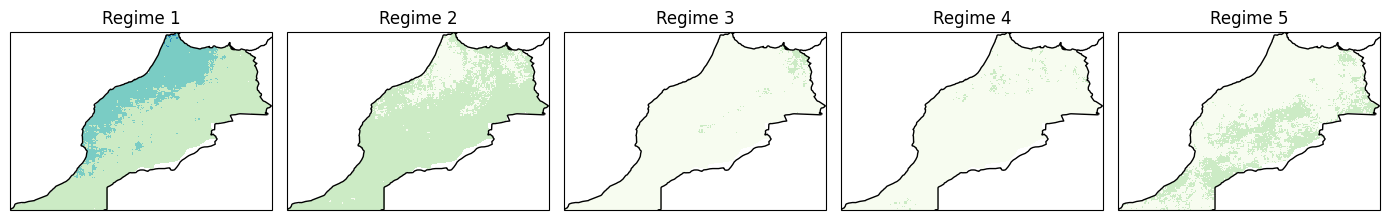

In [31]:
k=5

labels = pd.read_csv(filepath_pca_kmeans+'cluster_labels_'+str(k)+'_preciporder.csv')['label'].values

pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='', 
                               color_scheme = 'GnBu', vmin = 0, vmax=5, steps=6, 
                               title = 'Odds ratio of 95th percentile precipitation',
                                         regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                     'Regime 4', 'Regime 5', 'Regime 6',
                                                                     'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                               borders=True, projection=ccrs.PlateCarree(central_longitude=0),
                                          col_number=k)#

plt.savefig(filepath_pca_kmeans+'precip_odds_ratio_'+str(k)+'_preciporder_newscale.png')